In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from textwrap import wrap

from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker

from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

# Reduce:

* [Single run](#single_run)
* [Multiple runs](#multiple_runs)

<a id='single_run'></a>
## Reduce single run

In [26]:
pgroup='p21533'
runnumber = 162

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str(pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0162


'/sf/alvra/data/p21533/raw/run0162-FeOx_timescan_10mM_7123eV/meta/scan.json'

In [28]:
with_TT    = True
Two_diodes = False

#reducedir='../Reduced_XANES_timescans_2/'
reducedir='/sf/alvra/data/p21533/work/Reduced_data/Timescans_XANES/'
saveflag = True

t0_offset = 0         # in fs

quantile_corr = 0.5

channel_delay_motor = channel_delay_topas
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

TT = TT_PSEN126

#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

# scan.readbacks = scan.readbacks[1:]
# scan.files = scan.files[1:]

LoadTimescansXANES(with_TT, Two_diodes, scan, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero, 
                   quantile_corr, saveflag, reducedir, run_name, t0_offset)
data, _ = load_reduced_data(pgroup, reducedir, [runnumber])
globals().update(data)

Processing: run0162-FeOx_timescan_10mM_7123eV
Step 53 of 53: Processing acq0053

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                  501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH1_VAL_GET             501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 10 / 10 -> 0% incomplete

---------------

# Plot the run

* [with TT](#TT)
* [without TT](#no_TT)

<a id='TT'></a>
## with TT

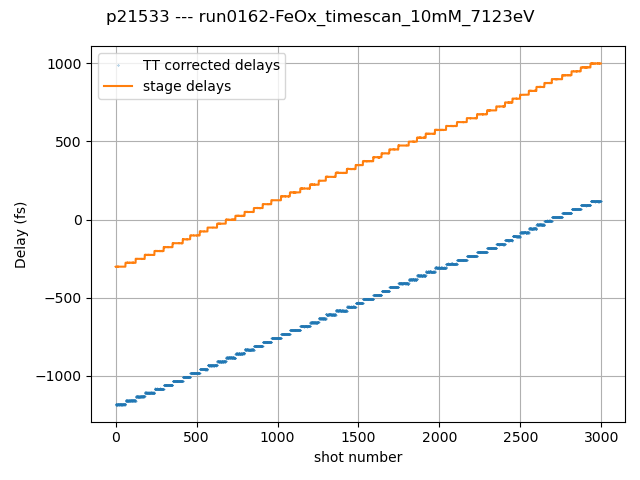

In [30]:
title=""
if Two_diodes:
    Pump_probe_scan  = Pump_probe_scan + Pump_probe_scan2
    Delays_corr_scan = Delays_corr_scan + Delays_corr_scan2
    Delays_fs_scan   = Delays_fs_scan + Delays_fs_scan2
    title = "Two diodes"

plt.figure()
plt.suptitle(titlestring)
plt.title(title)
plt.plot(Delays_corr_scan, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_fs_scan, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.tight_layout()
plt.show()

### Choose parameters and rebin

(2998,) (2998,) (2998,)
Rebin with 28 bins of 50 fs
Rebin delay stage positions


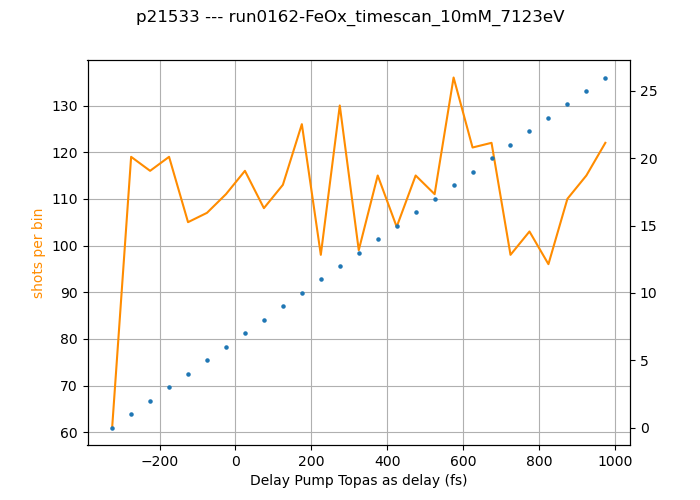

In [34]:
variable_bins = False
withTT = False

numbins = 100

binsize = 50
min_delay = -350
max_delay = 1050

######################################################################################

Delay_fs_TT, pp_TT, pp_std, err_pp, count, binsize = rebin_XANES(Pump_probe_scan, Delays_corr_scan, Delays_fs_scan, 
                                                                 variable_bins, withTT, numbins, binsize, min_delay, max_delay)

fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

delayrange = np.arange(0, len(Delay_fs_TT), 1)
ax1.plot(Delay_fs_TT, np.array(count), color = 'darkorange')
ax2.scatter(Delay_fs_TT, delayrange, s = 5)

ax1.set_xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
ax1.set_ylabel('shots per bin', color='darkorange')
ax1.grid()
plt.show()

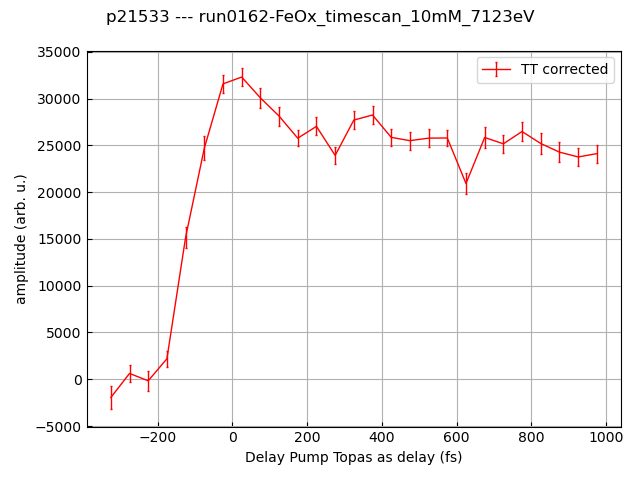

In [35]:
fitflag = False

fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle(titlestring)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

plt.tick_params(direction='in')

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corrected')

plt.xlabel("{} ({})".format(label, units))
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    #fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    #fit.p0 = better_p0(fit.p0, 4,100)
    fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs)))
    print("t0 = {:.4f} fs".format(t0_fs))

plt.grid()
#plt.axvline(t0_fs)
plt.tight_layout()
plt.show()

<a id='no_TT'></a>
## without TT

Scan is done with the stage in fs


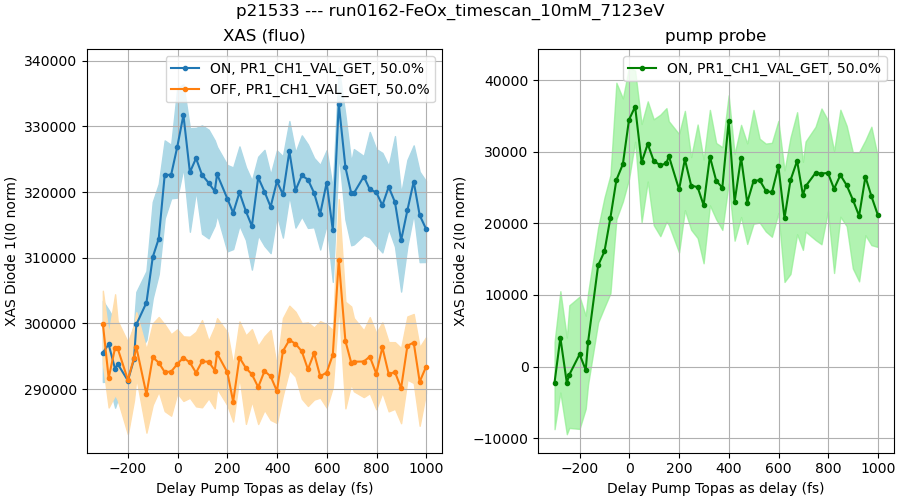

In [29]:
if Two_diodes:
    XAS1_pump_probe, XAS2_pump_probe, Delay_fs = Plot_2diodes_3figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=True)
    Delay_fs, ave_pp1 = Plot_2diodes_Averaged_2figs(titlestring, scan, data, timescan=True)
else:
    XAS1_pump_probe, Delay_fs = Plot_1diode(titlestring, scan, data, 
                                            quantile_corr, detector_XAS_1, timescan=True)

In [18]:
XAS2fit = XAS1_pump_probe
legend = detector_XAS_1
if Two_diodes:
    XAS2fit = ave_pp1
    legend = "Averaged"
    
###################################################

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Delay_fs, XAS2fit)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 

fit.fit(Delay_fs,XAS2fit)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
width_fs = fit.popt[2]

print ("Width = {:.3f} {}".format(abs(width_fs), units))
print ("Position t0 = {:.3f} {}".format(t0_fs, units))

Width = 2.765 fs
Position t0 = 614.705 fs


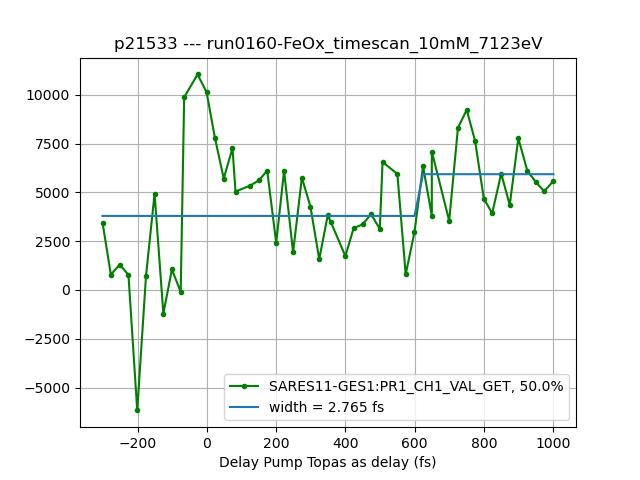

In [19]:
plt.figure()
units = scan.parameters['units'][0]
label = scan.parameters['name'][0]
plt.title(titlestring)
plt.plot(Delay_fs, XAS2fit, label='{}, {}%'.format(legend, quantile_corr*100),color='green',marker='.')
plt.plot(Delay_fs, pp_fit, label = 'width = {:.3f} fs'.format(abs(width_fs)))
plt.legend(loc='best')
plt.xlabel("{} ({})".format(label, units))
plt.grid()
plt.show()

<a id='multiple_runs'></a>
## Reduce multiple runs

In [ ]:
runlist = [202, 206]


#####################################
jsonlist = []
for run in runlist:
    jsonlist.append(glob.glob('/sf/alvra/data/p21604/raw/*{:04d}*/meta/scan.json'.format(run))[0])
jsonlist

In [ ]:
with_TT    = True
Two_diodes = True

reducedir='../Reduced_XANES_timescans/'

saveflag=True

quantile_corr = 0.5

channel_delay_motor = channel_delay_topas
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

TT = TT_PSEN126

#######################################################################################################

for jsonfile in jsonlist:
    
    from sfdata import SFScanInfo
    scan = SFScanInfo(jsonfile)
    scan = remove_JF_from_scan(scan)
    
    run_name = jsonfile.split('/')[-3]

    LoadTimescansXANES(with_TT, Two_diodes, scan, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr, saveflag, reducedir, run_name)
